In [26]:
import kagglehub
nodoubttome_skin_cancer9_classesisic_path = kagglehub.dataset_download('nodoubttome/skin-cancer9-classesisic')

print('Data source import complete.')


Data source import complete.


In [27]:
!nvidia-smi

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))


Wed Jun 18 00:25:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [28]:
# Cài đặt thư viện nếu cần
!pip install seaborn scikit-learn

# Import các thư viện cần thiết
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import json
from datetime import datetime

# Import Keras layers & callbacks
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Input, LayerNormalization,
    MultiHeadAttention, Add, GlobalAveragePooling1D,
    Embedding, Reshape, Permute
)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, accuracy_score
)

# Import multiprocessing
import concurrent.futures
import multiprocessing

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" Đã cấu hình {len(gpus)} GPU:")
        for i, gpu in enumerate(gpus):
            print(f"  - GPU {i}: {gpu}")
    except RuntimeError as e:
        print(f" Lỗi khi cấu hình GPU: {e}")
else:
    print(" Không tìm thấy GPU. Hãy bật GPU trong Runtime > Change runtime type > Hardware accelerator > GPU.")

# Kiểm tra thêm bằng cách in tên thiết bị được dùng bởi TensorFlow
device_name = tf.test.gpu_device_name()
if device_name:
    print(f" TensorFlow đang sử dụng: {device_name}")
else:
    print(" TensorFlow không phát hiện GPU.")

max_workers = min(multiprocessing.cpu_count(), 8)  # Tránh quá tải Colab
print(f" Số lượng CPU cores sử dụng: {max_workers}")

tf.random.set_seed(42)
np.random.seed(42)


 Đã cấu hình 2 GPU:
  - GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
  - GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
 TensorFlow đang sử dụng: /device:GPU:0
 Số lượng CPU cores sử dụng: 4


I0000 00:00:1750206320.024267      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750206320.024556      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [29]:
def create_dataframe(data_dir):
    """Tạo DataFrame từ cấu trúc thư mục ảnh"""
    data = []
    class_names = sorted(os.listdir(data_dir))
    for label, dir_name in enumerate(class_names):
        class_path = os.path.join(data_dir, dir_name)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    data.append({
                        "image_path": os.path.join(class_path, fname),
                        "label": label,
                        "class_name": dir_name
                    })
    return pd.DataFrame(data), class_names

# Hàm resize ảnh
def resize_image_array(image_path, target_size=(128, 128)):
    """Resize ảnh về kích thước target_size"""
    try:
        with Image.open(image_path) as img:
            img_resized = img.resize(target_size)
            return np.asarray(img_resized)
    except Exception as e:
        print(f"Lỗi xử lý ảnh {image_path}: {e}")
        return np.zeros((*target_size, 3), dtype=np.uint8)

# Hàm vẽ lịch sử training
def plot_training_history(history, title_prefix="Model"):
    """Vẽ đồ thị accuracy và loss trong quá trình training"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'{title_prefix} - Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'{title_prefix} - Training and Validation Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Hàm vẽ confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Vẽ confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Hàm vẽ phân phối dữ liệu
def plot_data_distribution(class_counts, class_names, title="Class Distribution"):
    """Vẽ biểu đồ phân phối các class"""
    plt.figure(figsize=(14, 8))
    bars = plt.bar(class_names, class_counts, alpha=0.8, color='skyblue', edgecolor='navy')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Thêm số lượng lên mỗi cột
    for bar, count in zip(bars, class_counts):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01*max(class_counts),
                f'{count}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Hàm vẽ sample images
def plot_sample_images(df, class_names, num_samples=9):
    """Vẽ ảnh mẫu từ mỗi class"""
    plt.figure(figsize=(15, 15))
    for i, class_label in enumerate(sorted(df['label'].unique())):
        if i >= num_samples:
            break
        # Lấy ảnh mẫu
        class_samples = df[df['label'] == class_label]
        if len(class_samples) > 0:
            sample = class_samples.sample(1).iloc[0]
            img = sample['image']

            plt.subplot(3, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_names[class_label]}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Hàm vẽ ROC curves
def plot_roc_curves(y_test, y_pred_proba, num_classes, class_names, title="ROC Curves"):
    """Vẽ ROC curves cho từng class"""
    plt.figure(figsize=(12, 10))

    # Compute ROC curve và ROC area cho mỗi class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right", bbox_to_anchor=(1.3, 0))
    plt.tight_layout()
    plt.show()

    return np.mean(list(roc_auc.values()))

# Hàm so sánh hiệu suất models
def compare_model_performance(results_dict):
    """So sánh hiệu suất giữa các models"""
    models = list(results_dict.keys())
    metrics = ['Accuracy', 'Loss', 'Training Time (min)']

    # Tạo DataFrame để hiển thị
    comparison_data = []
    for model_name, results in results_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Test Accuracy': f"{results['test_accuracy']:.4f}",
            'Test Loss': f"{results['test_loss']:.4f}",
            'Training Time (min)': f"{results['training_time']:.2f}",
            'Parameters': f"{results.get('total_params', 'N/A'):,}"
        })

    comparison_df = pd.DataFrame(comparison_data)

    # Hiển thị bảng so sánh
    print("=" * 80)
    print("                    MODEL PERFORMANCE COMPARISON")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    print("=" * 80)

    # Vẽ biểu đồ so sánh
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy comparison
    accuracies = [results_dict[model]['test_accuracy'] for model in models]
    ax1.bar(models, accuracies, color=['skyblue', 'lightcoral'])
    ax1.set_title('Test Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # Loss comparison
    losses = [results_dict[model]['test_loss'] for model in models]
    ax2.bar(models, losses, color=['skyblue', 'lightcoral'])
    ax2.set_title('Test Loss Comparison')
    ax2.set_ylabel('Loss')
    for i, v in enumerate(losses):
        ax2.text(i, v + 0.01*max(losses), f'{v:.3f}', ha='center', va='bottom')

    # Training time comparison
    times = [results_dict[model]['training_time'] for model in models]
    ax3.bar(models, times, color=['skyblue', 'lightcoral'])
    ax3.set_title('Training Time Comparison')
    ax3.set_ylabel('Time (minutes)')
    for i, v in enumerate(times):
        ax3.text(i, v + 0.01*max(times), f'{v:.1f}', ha='center', va='bottom')

    # Parameters comparison (if available)
    params = [results_dict[model].get('total_params', 0) for model in models]
    if any(p > 0 for p in params):
        ax4.bar(models, [p/1e6 for p in params], color=['skyblue', 'lightcoral'])
        ax4.set_title('Model Parameters Comparison')
        ax4.set_ylabel('Parameters (Millions)')
        for i, v in enumerate(params):
            if v > 0:
                ax4.text(i, v/1e6 + 0.01*max(params)/1e6, f'{v/1e6:.1f}M', ha='center', va='bottom')
    else:
        ax4.text(0.5, 0.5, 'Parameter data\nnot available',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Model Parameters')

    plt.tight_layout()
    plt.show()

    return comparison_df

# Hàm lưu kết quả
def save_results(results, filename):
    """Lưu kết quả vào file JSON"""
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)
    print(f" Kết quả đã được lưu vào {filename}")

print(" Các hàm tiện ích đã được định nghĩa!")


 Các hàm tiện ích đã được định nghĩa!


In [30]:
try:
    dataset_path = kagglehub.dataset_download('nodoubttome/skin-cancer9-classesisic')
    print(f" Dataset đã được tải về: {dataset_path}")
except Exception as e:
    print(f" Lỗi tải dataset: {e}")
    print("Vui lòng kiểm tra kết nối internet và API token Kaggle")

# Thiết lập đường dẫn
train_dir = os.path.join(dataset_path, 'Skin cancer ISIC The International Skin Imaging Collaboration/Train')
test_dir = os.path.join(dataset_path, 'Skin cancer ISIC The International Skin Imaging Collaboration/Test')

print(f" Thư mục train: {train_dir}")
print(f" Thư mục test: {test_dir}")

 Dataset đã được tải về: /kaggle/input/skin-cancer9-classesisic
 Thư mục train: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train
 Thư mục test: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [31]:
# Cấu hình xử lý dữ liệu
CONFIG = {
    'max_images_per_class': 2000,
    'image_size': (224, 224),
    'batch_size': 32,
    'validation_split': 0.2,
    'test_split': 0.2,
    'random_state': 42
}

print(" Cấu hình xử lý dữ liệu:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Tạo DataFrame
print("\n Đang tạo DataFrame từ dữ liệu...")

try:
    train_df, class_names = create_dataframe(train_dir)
    test_df, _ = create_dataframe(test_dir)
    df = pd.concat([train_df, test_df], ignore_index=True)
    print(f" Đã tạo DataFrame với {len(df)} ảnh")
    print(f" Số lượng classes: {len(class_names)}")
    print(f" Tên các classes: {class_names}")
except Exception as e:
    print(f"❌ Lỗi tạo DataFrame: {e}")

 Cấu hình xử lý dữ liệu:
  max_images_per_class: 2000
  image_size: (224, 224)
  batch_size: 32
  validation_split: 0.2
  test_split: 0.2
  random_state: 42

 Đang tạo DataFrame từ dữ liệu...
 Đã tạo DataFrame với 2357 ảnh
 Số lượng classes: 9
 Tên các classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [32]:
# Label mapping
label_map = {i: name for i, name in enumerate(class_names)}
num_classes = len(label_map)
print("\n Label mapping:")
for label, name in label_map.items():
    print(f"  {label}: {name}")


 Label mapping:
  0: actinic keratosis
  1: basal cell carcinoma
  2: dermatofibroma
  3: melanoma
  4: nevus
  5: pigmented benign keratosis
  6: seborrheic keratosis
  7: squamous cell carcinoma
  8: vascular lesion


In [33]:
# Giới hạn ảnh/class
print(f"\n Đang giới hạn dữ liệu ({CONFIG['max_images_per_class']} ảnh/class)...")
df_limited = df.groupby("label").head(CONFIG['max_images_per_class']).reset_index(drop=True)
print(f" Dataset sau giới hạn: {len(df_limited)} ảnh")



 Đang giới hạn dữ liệu (2000 ảnh/class)...
 Dataset sau giới hạn: 2357 ảnh



 Phân phối dữ liệu ban đầu:
  actinic keratosis   :   130 ảnh
  basal cell carcinoma:   392 ảnh
  dermatofibroma      :   111 ảnh
  melanoma            :   454 ảnh
  nevus               :   373 ảnh
  pigmented benign keratosis:   478 ảnh
  seborrheic keratosis:    80 ảnh
  squamous cell carcinoma:   197 ảnh
  vascular lesion     :   142 ảnh


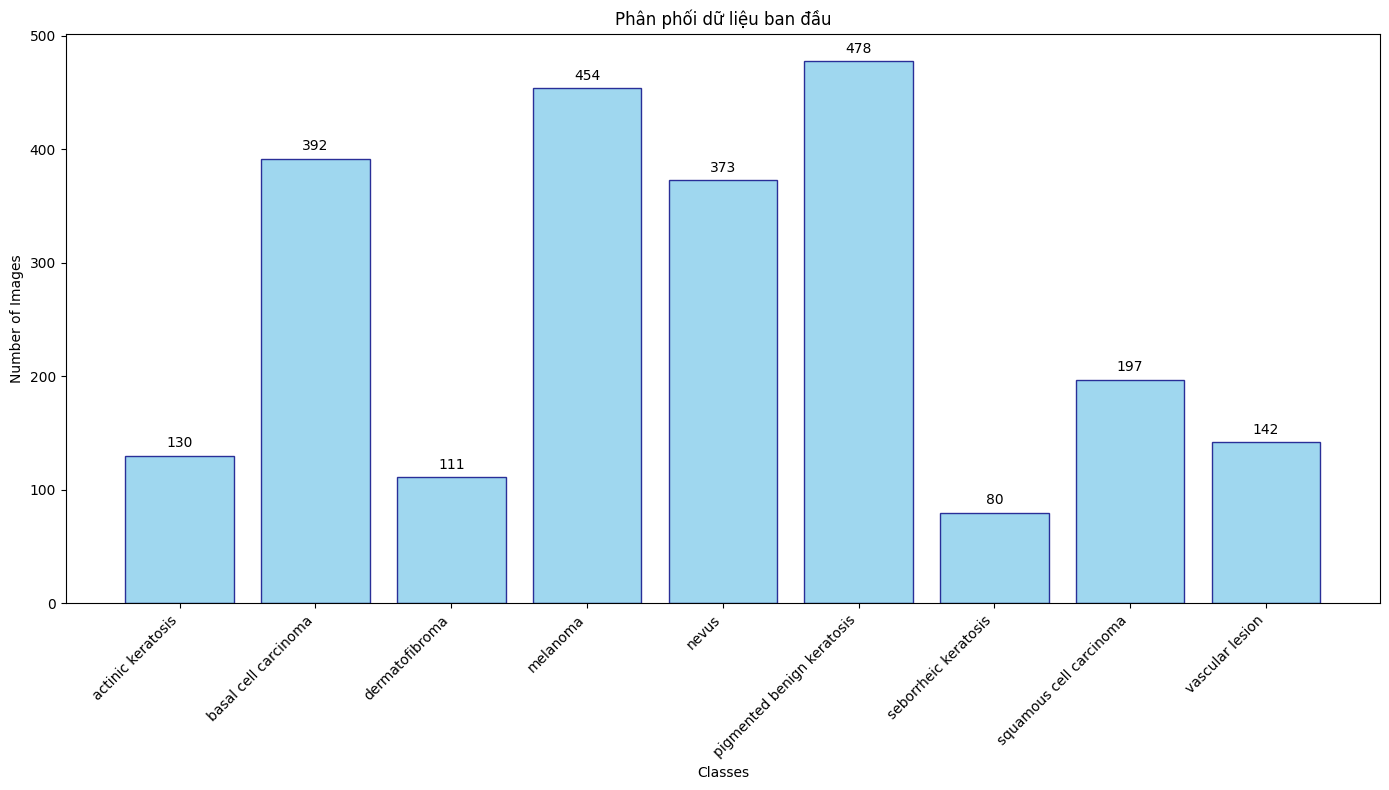

In [34]:
# Phân phối ban đầu
class_counts = df_limited['label'].value_counts().sort_index()
print("\n Phân phối dữ liệu ban đầu:")
for i, count in enumerate(class_counts):
    print(f"  {class_names[i]:20}: {count:5d} ảnh")
plot_data_distribution(class_counts.values, class_names, "Phân phối dữ liệu ban đầu")


In [35]:
# Resize ảnh
print(f"\n Đang resize ảnh về kích thước {CONFIG['image_size']}...")
start_time = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    def resize_func(path):
        return resize_image_array(path, CONFIG['image_size'])
    df_limited['image'] = list(executor.map(resize_func, df_limited['image_path']))
resize_time = time.time() - start_time
print(f" Hoàn thành resize trong {resize_time:.1f} giây")



 Đang resize ảnh về kích thước (224, 224)...
 Hoàn thành resize trong 18.0 giây


In [36]:
# Augmentation
print("\n Thiết lập data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


 Thiết lập data augmentation...


 Đang balance dữ liệu bằng augmentation...
  Class actinic keratosis   :  130 ->  478
  Class basal cell carcinoma:  392 ->  478
  Class dermatofibroma      :  111 ->  478
  Class melanoma            :  454 ->  478
  Class nevus               :  373 ->  478
  Class pigmented benign keratosis:  478 ->  478
  Class seborrheic keratosis:   80 ->  478
  Class squamous cell carcinoma:  197 ->  478
  Class vascular lesion     :  142 ->  478
 Dataset sau balancing: 4302 ảnh

 Phân phối dữ liệu sau balancing:
  actinic keratosis   :   478 ảnh
  basal cell carcinoma:   478 ảnh
  dermatofibroma      :   478 ảnh
  melanoma            :   478 ảnh
  nevus               :   478 ảnh
  pigmented benign keratosis:   478 ảnh
  seborrheic keratosis:   478 ảnh
  squamous cell carcinoma:   478 ảnh
  vascular lesion     :   478 ảnh


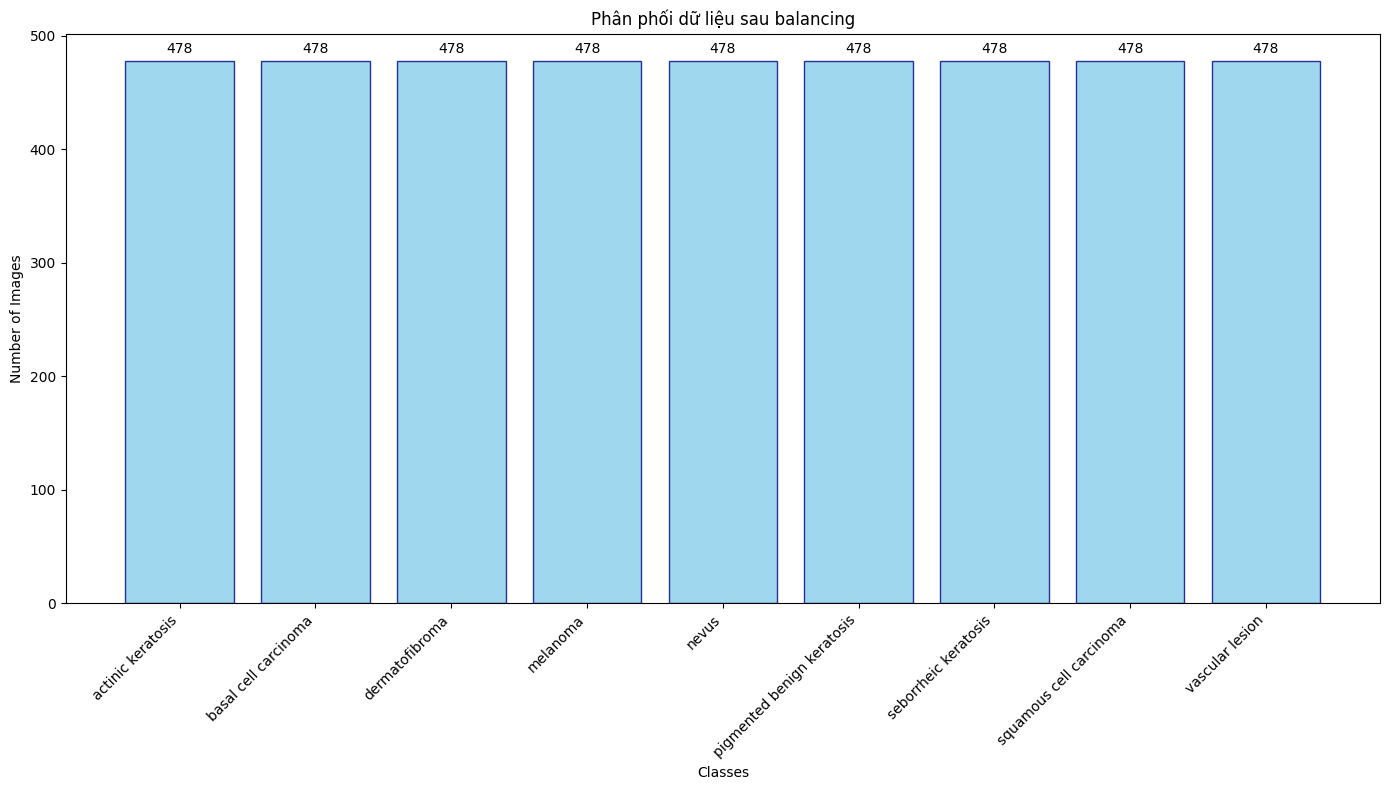


 Hiển thị ảnh mẫu từ các classes:


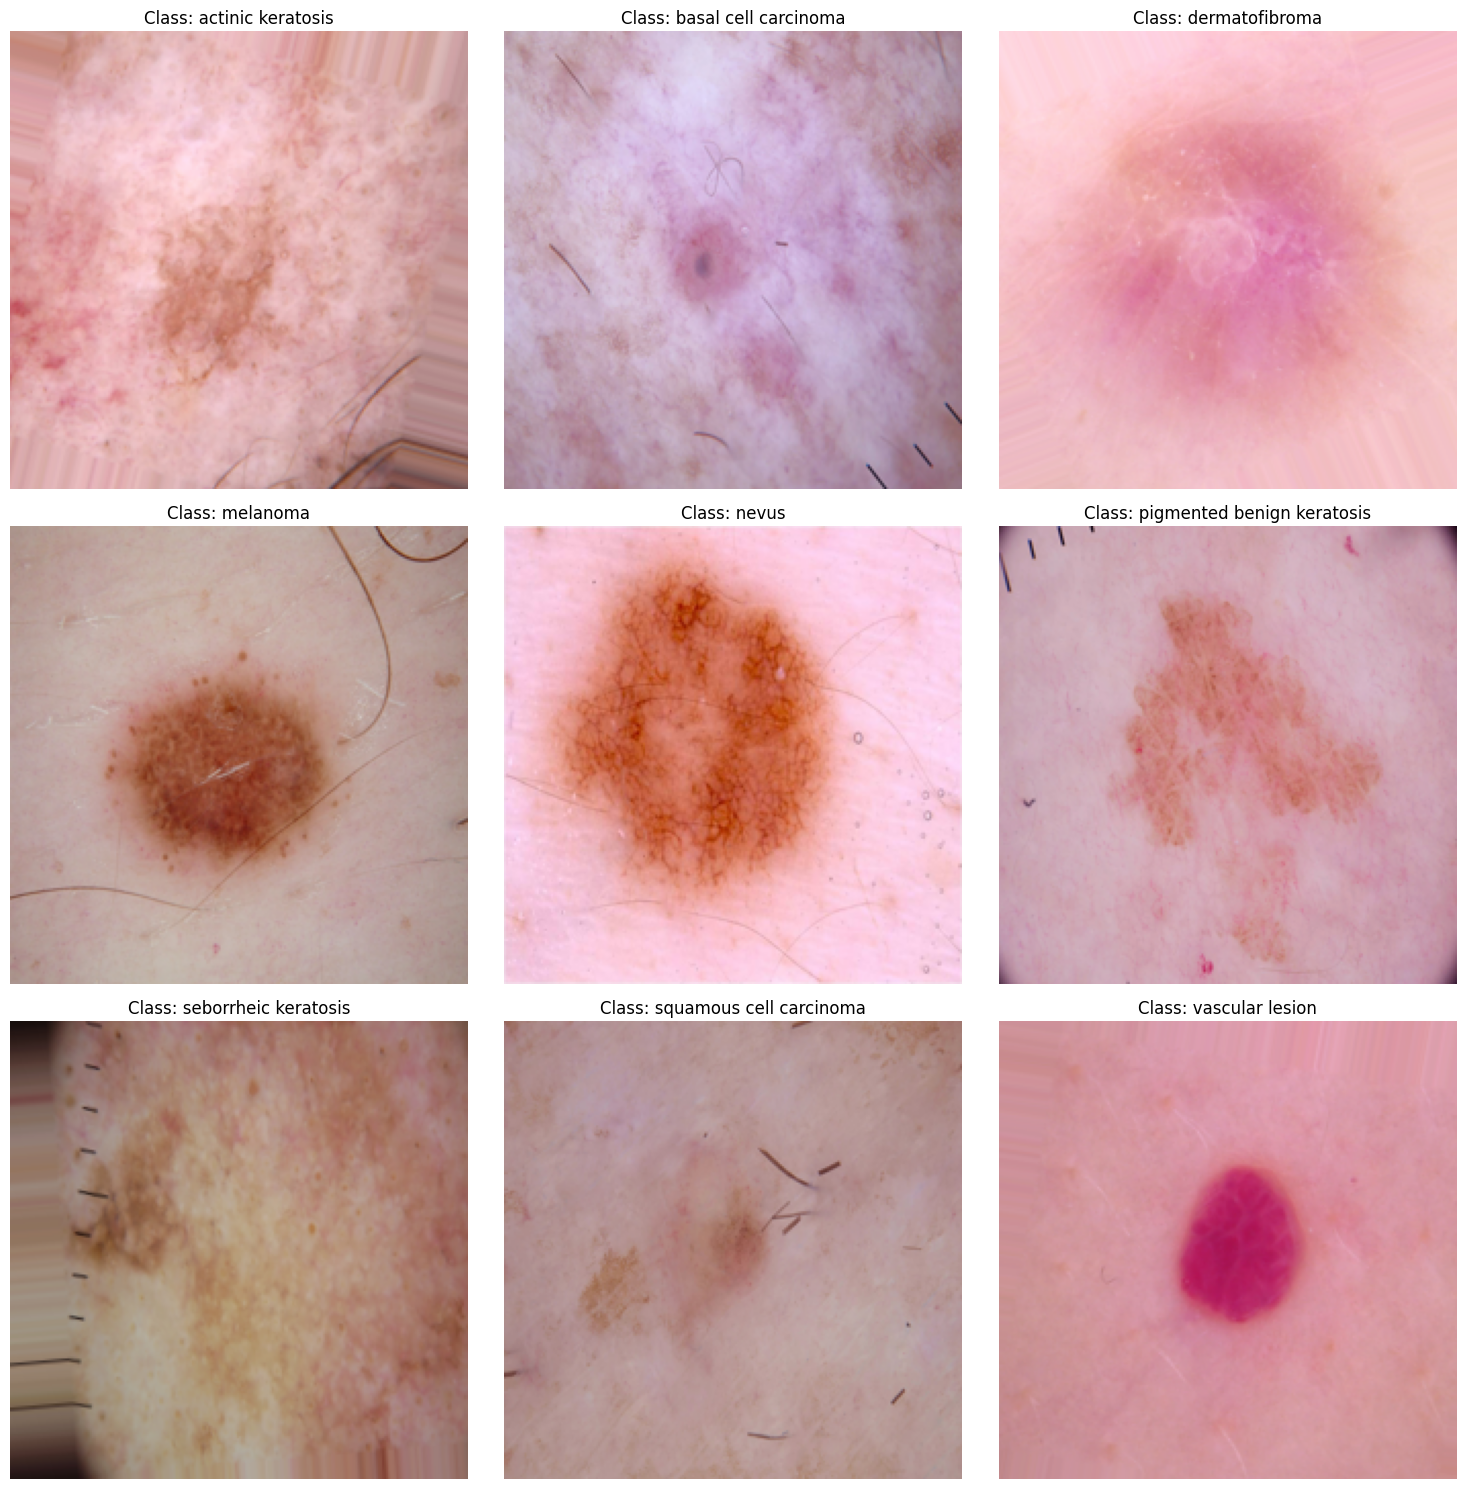

In [37]:
# Balance
print(" Đang balance dữ liệu bằng augmentation...")
max_class_count = class_counts.max()
balanced_df = pd.DataFrame(columns=df_limited.columns)

for class_label in range(num_classes):
    class_data = df_limited[df_limited['label'] == class_label].copy()
    current_count = len(class_data)
    print(f"  Class {class_names[class_label]:20}: {current_count:4d} -> {max_class_count:4d}")
    balanced_df = pd.concat([balanced_df, class_data], ignore_index=True)
    if current_count < max_class_count:
        needed = max_class_count - current_count
        augment_indices = np.random.choice(len(class_data), size=needed, replace=True)
        for idx in augment_indices:
            original_img = class_data.iloc[idx]['image']
            img_array = np.expand_dims(original_img, axis=0)
            augmented_generator = datagen.flow(img_array, batch_size=1)
            augmented_img = next(augmented_generator)[0].astype('uint8')
            new_row = class_data.iloc[idx].copy()
            new_row['image'] = augmented_img
            new_row['image_path'] = f"augmented_{class_label}_{idx}"
            balanced_df = pd.concat([balanced_df, new_row.to_frame().T], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=CONFIG['random_state']).reset_index(drop=True)
print(f" Dataset sau balancing: {len(balanced_df)} ảnh")

balanced_counts = balanced_df['label'].value_counts().sort_index()
print("\n Phân phối dữ liệu sau balancing:")
for i, count in enumerate(balanced_counts):
    print(f"  {class_names[i]:20}: {count:5d} ảnh")
plot_data_distribution(balanced_counts.values, class_names, "Phân phối dữ liệu sau balancing")
print("\n Hiển thị ảnh mẫu từ các classes:")
plot_sample_images(balanced_df, class_names)


### Processing data 

In [38]:
# Chia train/val/test
print("\n Đang chia dữ liệu train/validation/test...")
X = np.array(balanced_df['image'].tolist())
y = balanced_df['label'].values
print(f"📊 Kích thước dữ liệu: X={X.shape}, y={y.shape}")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=CONFIG['test_split'],
    stratify=y,
    random_state=CONFIG['random_state']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=CONFIG['validation_split'],
    stratify=y_train_val,
    random_state=CONFIG['random_state']
)
print(f" Chia dữ liệu hoàn thành:")
print(f"   Train:      {X_train.shape[0]:5d} ảnh")
print(f"   Validation: {X_val.shape[0]:5d} ảnh")
print(f"   Test:       {X_test.shape[0]:5d} ảnh")



 Đang chia dữ liệu train/validation/test...
📊 Kích thước dữ liệu: X=(4302, 224, 224, 3), y=(4302,)
 Chia dữ liệu hoàn thành:
   Train:       2752 ảnh
   Validation:   689 ảnh
   Test:         861 ảnh


In [39]:
# Normalize
print("\n Đang normalize dữ liệu...")
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
print(f" Normalize hoàn thành (mean={X_train_mean:.2f}, std={X_train_std:.2f})")

# One-hot encode
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
print(" One-hot encoding hoàn thành")


 Đang normalize dữ liệu...
 Normalize hoàn thành (mean=164.82, std=41.27)
 One-hot encoding hoàn thành


In [40]:
# Thống kê
print("\n" + "="*80)
print("                    TỔNG QUAN Dắu LIỆU CUỐI CÙNG")
print("="*80)
split_summary = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Number of Images': [len(X_train), len(X_val), len(X_test), len(X_train) + len(X_val) + len(X_test)],
    'Percentage': [
        f"{len(X_train)/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%",
        f"{len(X_val)/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%",
        f"{len(X_test)/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%",
        "100.0%"
    ]
})
print(split_summary.to_string(index=False))
print("="*80)

train_class_counts = np.sum(y_train_cat, axis=0)
val_class_counts = np.sum(y_val_cat, axis=0)
test_class_counts = np.sum(y_test_cat, axis=0)
class_distribution = pd.DataFrame({
    'Class': class_names,
    'Train': train_class_counts.astype(int),
    'Validation': val_class_counts.astype(int),
    'Test': test_class_counts.astype(int)
})
print("\n PHÂN PHỐI CLASSES:")
print(class_distribution.to_string(index=False))


                    TỔNG QUAN Dắu LIỆU CUỐI CÙNG
     Split  Number of Images Percentage
     Train              2752      64.0%
Validation               689      16.0%
      Test               861      20.0%
     Total              4302     100.0%

 PHÂN PHỐI CLASSES:
                     Class  Train  Validation  Test
         actinic keratosis    306          76    96
      basal cell carcinoma    306          77    95
            dermatofibroma    306          76    96
                  melanoma    306          76    96
                     nevus    305          77    96
pigmented benign keratosis    306          77    95
      seborrheic keratosis    305          77    96
   squamous cell carcinoma    306          77    95
           vascular lesion    306          76    96


### Train

In [41]:
!pip install --upgrade wandb
import wandb
wandb.login(key="bc144091effe26789524d4b4ebf792d7fbdda92c")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

### CNN pretrained and fine tune DenseNet201 

In [42]:

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger


# Định nghĩa lại CONFIG nếu chưa có
if 'CONFIG' not in globals():
    CONFIG = {
        'image_size': (224, 224),
        'batch_size': 32,
        'validation_split': 0.2,
        'test_split': 0.2,
        'random_state': 42
    }

# Cấu hình CNN model
CNN_CONFIG = {
    'learning_rate': 0.001,
    'momentum': 0.9,
    'dropout_rate': 0.5,
    'batch_size': CONFIG['batch_size'],
    'epochs': 15,
    'optimizer': 'sgd',  # 'sgd' hoặc 'adam'
    'freeze_base': True,  # Có freeze base layers không
    'fine_tune_from': 100,  # Layer nào bắt đầu fine-tune
    'patience': 10,
    'reduce_lr_patience': 5
}

print(" Đang thiết lập model CNN (DenseNet201)...")
print(" Cấu hình CNN:")
for key, value in CNN_CONFIG.items():
    print(f"  {key}: {value}")

# Khởi tạo W&B run cho CNN
wandb.init(
    project="skin-cancer-cnn",
    name="cnn-densenet201-experiment",
    config={
        **CONFIG,
        **CNN_CONFIG,
        'model_type': 'CNN-DenseNet201',
        'num_classes': num_classes,
        'input_shape': (*CONFIG['image_size'], 3)
    },
    tags=['CNN', 'DenseNet201', 'Transfer Learning', 'Skin Cancer']
)

def create_cnn_model(input_shape, num_classes, config):
    """
    Tạo CNN model sử dụng DenseNet201 backbone
    """
    print(f"🏗️ Đang tạo CNN model với input shape: {input_shape}")

    # Load DenseNet201 pre-trained
    base_model = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )

    print(f" DenseNet201 base model có {len(base_model.layers)} layers")
    print(f" Total parameters trong base model: {base_model.count_params():,}")

    # Thêm custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pooling')(x)
    x = Dense(512, activation='relu', name='dense_512')(x)
    x = Dropout(config['dropout_rate'], name='dropout_1')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(config['dropout_rate'], name='dropout_2')(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)


    model = Model(inputs=base_model.input, outputs=predictions, name='CNN_DenseNet201')

    if config['freeze_base']:
        print(" Đang freeze base model layers...")
        for layer in base_model.layers:
            layer.trainable = False
        print(" Đã freeze base model layers")
    else:
        print(" Keeping all layers trainable")

    # Fine-tuning option
    if config.get('fine_tune_from'):
        print(f" Fine-tuning từ layer {config['fine_tune_from']} trở đi...")
        for layer in base_model.layers[config['fine_tune_from']:]:
            layer.trainable = True

    return model

# Tạo CNN model
try:
    cnn_model = create_cnn_model(
        input_shape=(*CONFIG['image_size'], 3),
        num_classes=num_classes,
        config=CNN_CONFIG
    )
    print(" CNN model đã được tạo thành công!")
except Exception as e:
    print(f" Lỗi tạo CNN model: {e}")
    raise

# Model summary
print("\n CNN Model Architecture:")
cnn_model.summary()

# Đếm parameters
total_params = cnn_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in cnn_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\n CNN Model Parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Non-trainable parameters: {non_trainable_params:,}")

# Log model info to W&B
wandb.log({
    "model/total_params": total_params,
    "model/trainable_params": trainable_params,
    "model/non_trainable_params": non_trainable_params
})

# Compile model
print("\n🔧 Đang compile CNN model...")

if CNN_CONFIG['optimizer'] == 'sgd':
    optimizer = SGD(
        learning_rate=CNN_CONFIG['learning_rate'],
        momentum=CNN_CONFIG['momentum']
    )
    print(f" Sử dụng SGD optimizer (lr={CNN_CONFIG['learning_rate']}, momentum={CNN_CONFIG['momentum']})")
elif CNN_CONFIG['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=CNN_CONFIG['learning_rate'])
    print(f" Sử dụng Adam optimizer (lr={CNN_CONFIG['learning_rate']})")

cnn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print(" CNN model đã được compile thành công!")

# Thiết lập callbacks
print("\n Đang thiết lập callbacks...")

callbacks = [
    WandbMetricsLogger(log_freq='epoch'),
    ModelCheckpoint(
        filepath="cnn_densenet201_best.h5",
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(" Callbacks đã được thiết lập:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

# Training function
def train_cnn_model(model, X_train, y_train, X_val, y_val, config, callbacks):
    """
    Training CNN model với W&B logging
    """
    print(f"\n Bắt đầu training CNN model...")
    print(f" Training data: {X_train.shape}")
    print(f" Validation data: {X_val.shape}")

    # Log training start
    wandb.log({"training/status": "started"})

    try:
        history = model.fit(
            X_train, y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1,
            shuffle=True
        )

        print(" Training hoàn thành!")
        wandb.log({"training/status": "completed"})
        return history

    except Exception as e:
        print(f" Lỗi trong quá trình training: {e}")
        wandb.log({"training/status": "failed", "training/error": str(e)})
        raise

# Chuẩn bị training (kiểm tra dữ liệu có tồn tại không)
if 'X_train' in globals() and 'y_train_cat' in globals():
    print("\n Dữ liệu training đã sẵn sàng")

    # Bắt đầu training
    cnn_history = train_cnn_model(
        model=cnn_model,
        X_train=X_train,
        y_train=y_train_cat,
        X_val=X_val,
        y_val=y_val_cat,
        config=CNN_CONFIG,
        callbacks=callbacks
    )


cnn_model.save("cnn_densenet201_final.h5")




 Đang thiết lập model CNN (DenseNet201)...
 Cấu hình CNN:
  learning_rate: 0.001
  momentum: 0.9
  dropout_rate: 0.5
  batch_size: 32
  epochs: 15
  optimizer: sgd
  freeze_base: True
  fine_tune_from: 100
  patience: 10
  reduce_lr_patience: 5


🏗️ Đang tạo CNN model với input shape: (224, 224, 3)


I0000 00:00:1750206374.713638      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750206374.713874      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 DenseNet201 base model có 707 layers
 Total parameters trong base model: 18,321,984
 Đang freeze base model layers...
 Đã freeze base model layers
 Fine-tuning từ layer 100 trở đi...
 CNN model đã được tạo thành công!

 CNN Model Architecture:


Model: "CNN_DenseNet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 19,372,361 (73.90 MB)

 Trainable params: 18,338,633 (69.96 MB)

 Non-trainable params: 1,033,728 (3.94 MB)


 CNN Model Parameters:
  Total parameters: 19,372,361
  Trainable parameters: 18,338,633
  Non-trainable parameters: 1,033,728

🔧 Đang compile CNN model...
 Sử dụng SGD optimizer (lr=0.001, momentum=0.9)
 CNN model đã được compile thành công!

 Đang thiết lập callbacks...
 Callbacks đã được thiết lập:
  - WandbMetricsLogger
  - ModelCheckpoint
  - EarlyStopping
  - ReduceLROnPlateau

 Dữ liệu training đã sẵn sàng

 Bắt đầu training CNN model...
 Training data: (2752, 224, 224, 3)
 Validation data: (689, 224, 224, 3)
Epoch 1/15


I0000 00:00:1750206467.590594     287 service.cc:148] XLA service 0x7867382a0020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750206467.591486     287 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750206467.591506     287 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750206474.305417     287 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750206686.811346     287 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.1721 - loss: 2.3133 - top_k_categorical_accuracy: 0.6537
Epoch 1: val_accuracy improved from -inf to 0.53556, saving model to cnn_densenet201_best.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 380s 935ms/step - accuracy: 0.1730 - loss: 2.3104 - top_k_categorical_accuracy: 0.6546 - val_accuracy: 0.5356 - val_loss: 1.5154 - val_top_k_categorical_accuracy: 0.9216 - learning_rate: 0.0010
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5080 - loss: 1.4163 - top_k_categorical_accuracy: 0.9213
Epoch 2: val_accuracy improved from 0.53556 to 0.63425, saving model to cnn_densenet201_best.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - accuracy: 0.5085 - loss: 1.4150 - top_k_categorical_accuracy: 0.9215 - val_accuracy: 0.6343 - val_loss: 0.9953 - val_top_k_categorical_accuracy: 0.9768 - learning_rate: 0.0010
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6745 - loss: 0.9607 - top_k_categorical_accuracy: 0.9743
Epoch 3: val

### VIT TỰ BUILD KO PRETRAIN (KERAS LỖI KO PRE AND FINE TUNE DC) 

In [43]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Cấu hình ViT model
VIT_CONFIG = {
    'patch_size': 16,  # Kích thước patch
    'projection_dim': 64,  # Số chiều embedding
    'num_heads': 4,  # Số heads trong Multi-Head Attention
    'transformer_layers': 8,  # Số Transformer blocks
    'mlp_head_units': [256, 128],  # Số units trong MLP head
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'batch_size': CONFIG['batch_size'],
    'epochs': 30,
    'dropout_rate': 0.1,
    'model_name': 'vit_skin_cancer'
}

print(" Cấu hình ViT:")
for key, value in VIT_CONFIG.items():
    print(f"  {key}: {value}")

# Khởi tạo W&B run cho ViT
wandb.init(
    project="skin-cancer-vit",
    name="vision_transformer",
    config={
        **VIT_CONFIG,
        'model_type': 'ViT',
        'image_size': CONFIG['image_size'],
        'num_classes': num_classes
    }
)

# Lớp chia ảnh thành các patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config



# Lớp PatchEncoder để encode patches và thêm position embeddings
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1,  # +1 cho [class] token
            output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim
        })
        return config

# Lớp MLP cho Transformer
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Transformer Block
def transformer_block(inputs, projection_dim, num_heads, dropout_rate):
    # Layer Normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-Head Attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim // num_heads
    )(x1, x1)

    # Skip connection 1
    x2 = layers.Add()([attention_output, inputs])

    # Layer Normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

    # MLP
    x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=dropout_rate)

    # Skip connection 2
    outputs = layers.Add()([x3, x2])

    return outputs

def create_vit_model(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_layers,
    mlp_head_units,
    num_classes,
    dropout_rate=0.1
):
    inputs = layers.Input(shape=input_shape)

    # Chia ảnh thành các patches
    patches = Patches(patch_size)(inputs)

    # Tạo class token
    def create_class_token(inputs):
        batch_size = tf.shape(inputs)[0]
        class_token = tf.zeros([batch_size, 1, projection_dim])
        return class_token

    class_token = layers.Lambda(create_class_token)(patches)

    # Embed patches
    token_embeddings = layers.Dense(projection_dim)(patches)

    # Concatenate class token
    token_embeddings = layers.Concatenate(axis=1)([class_token, token_embeddings])

    # Position embeddings
    positions = tf.range(start=0, limit=num_patches + 1, delta=1)
    position_embeddings = layers.Embedding(
        input_dim=num_patches + 1,
        output_dim=projection_dim
    )(positions)

    # Add position embedding
    position_embeddings = layers.Lambda(lambda x: x[0] + x[1])([token_embeddings, position_embeddings])

    x = position_embeddings

    # Transformer blocks
    for _ in range(transformer_layers):
        x = transformer_block(x, projection_dim, num_heads, dropout_rate)

    # MLP head
    x = layers.LayerNormalization(epsilon=1e-6)(x[:, 0])
    for units in mlp_head_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model



# Tính toán số lượng patches
image_size = CONFIG['image_size'][0]  # Giả sử ảnh vuông
patch_size = VIT_CONFIG['patch_size']
num_patches = (image_size // patch_size) ** 2
print(f" Số lượng patches: {num_patches} (ảnh {image_size}x{image_size}, patch {patch_size}x{patch_size})")

# Tạo ViT model
input_shape = (*CONFIG['image_size'], 3)
vit_model = create_vit_model(
    input_shape=input_shape,
    patch_size=VIT_CONFIG['patch_size'],
    num_patches=num_patches,
    projection_dim=VIT_CONFIG['projection_dim'],
    num_heads=VIT_CONFIG['num_heads'],
    transformer_layers=VIT_CONFIG['transformer_layers'],
    mlp_head_units=VIT_CONFIG['mlp_head_units'],
    num_classes=num_classes,
    dropout_rate=VIT_CONFIG['dropout_rate']
)

# Compile model
optimizer = Adam(
    learning_rate=VIT_CONFIG['learning_rate'],
    weight_decay=VIT_CONFIG['weight_decay']
)

vit_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

# Hiển thị model summary
print("\n ViT Model Summary:")
vit_model.summary()

# Tạo callbacks
vit_callbacks = [
    WandbMetricsLogger(log_freq='epoch'),
    ModelCheckpoint(
        filepath=f"{VIT_CONFIG['model_name']}_best.h5",
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n Đang huấn luyện ViT model...")
vit_history = vit_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    batch_size=VIT_CONFIG['batch_size'],
    epochs=VIT_CONFIG['epochs'],
    callbacks=vit_callbacks,
    verbose=1
)

# Đánh giá model trên tập test
print("\n Đang đánh giá ViT model trên tập test...")
vit_test_results = vit_model.evaluate(X_test, y_test_cat, verbose=1)
print(f" ViT Test Loss: {vit_test_results[0]:.4f}")
print(f" ViT Test Accuracy: {vit_test_results[1]:.4f}")
print(f" ViT Test Top-5 Accuracy: {vit_test_results[2]:.4f}")

# Lưu kết quả vào wandb
wandb.log({
    "vit_test_loss": vit_test_results[0],
    "vit_test_accuracy": vit_test_results[1],
    "vit_test_top5_acc": vit_test_results[2]
})

# Lưu model final
vit_model.save(f"{VIT_CONFIG['model_name']}_final.h5")
print(f" ViT model được lưu vào {VIT_CONFIG['model_name']}_final.h5")

wandb.finish()




 Cấu hình ViT:
  patch_size: 16
  projection_dim: 64
  num_heads: 4
  transformer_layers: 8
  mlp_head_units: [256, 128]
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 32
  epochs: 30
  dropout_rate: 0.1
  model_name: vit_skin_cancer


 Số lượng patches: 196 (ảnh 224x224, patch 16x16)

 ViT Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches (Patches)         │ (None, None, 768)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1, 64)          │              0 │ patches[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 64)       │         49,216 │ patches[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 64)       │              0 │ lambda[0][0],          │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 197, 64)        │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 197, 64)        │            128 │ lambda_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 197, 64)        │         16,640 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 197, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 197, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 197, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 197, 128)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 197, 64)        │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 197, 64)        │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 197, 64)        │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 197, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization) 

 Total params: 367,817 (1.40 MB)

 Trainable params: 367,817 (1.40 MB)

 Non-trainable params: 0 (0.00 B)


 Đang huấn luyện ViT model...
Epoch 1/30
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1932 - loss: 2.0402 - top5_acc: 0.7253
Epoch 1: val_accuracy improved from -inf to 0.26415, saving model to vit_skin_cancer_best.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 62s 121ms/step - accuracy: 0.1944 - loss: 2.0370 - top5_acc: 0.7272 - val_accuracy: 0.2642 - val_loss: 1.7443 - val_top5_acc: 0.8839 - learning_rate: 0.0010
Epoch 2/30
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3072 - loss: 1.7188 - top5_acc: 0.8736
Epoch 2: val_accuracy improved from 0.26415 to 0.33962, saving model to vit_skin_cancer_best.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.3081 - loss: 1.7178 - top5_acc: 0.8739 - val_accuracy: 0.3396 - val_loss: 1.6160 - val_top5_acc: 0.8984 - learning_rate: 0.0010
Epoch 3/30
85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3785 - loss: 1.5682 - top5_acc: 0.9162
Epoch 3: val_accuracy improved from 0.33962 to 0.38316, saving model to vit_skin_cancer_best.h5
86/86 

### ĐÁNH GIÁ MODEL 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
import wandb


# Khởi tạo W&B run mới cho so sánh
wandb.init(
    project="skin-cancer-CHECK_CNN_VIT",
    name="model_comparison",
    config={
        'models': ['CNN (DenseNet201)', 'Vision Transformer (ViT)'],
        'image_size': CONFIG['image_size'],
        'num_classes': num_classes
    }
)

# Load các models đã lưu (nếu cần)
try:
    print(" Đang load các models...")
    # Sử dụng models từ memory nếu vẫn còn
    if 'cnn_model' not in locals():
        cnn_model = tf.keras.models.load_model(f"{CNN_CONFIG['model_name']}_best.h5")
    if 'vit_model' not in locals():
        vit_model = tf.keras.models.load_model(f"{VIT_CONFIG['model_name']}_best.h5")
    print(" Load models thành công!")
except Exception as e:
    print(f" Lỗi khi load models: {e}")
    print("Sử dụng models từ memory...")

 Đang load các models...
 Load models thành công!


In [45]:
# Dự đoán trên tập test
print(" Đang dự đoán trên tập test...")
cnn_preds = cnn_model.predict(X_test, batch_size=32, verbose=1)
vit_preds = vit_model.predict(X_test, batch_size=32, verbose=1)

# Tính toán các metrics
print(" Đang tính toán metrics...")

# Accuracy
cnn_accuracy = np.sum(np.argmax(cnn_preds, axis=1) == np.argmax(y_test_cat, axis=1)) / len(y_test_cat)
vit_accuracy = np.sum(np.argmax(vit_preds, axis=1) == np.argmax(y_test_cat, axis=1)) / len(y_test_cat)

# Top-5 Accuracy
cnn_top5_acc = tf.keras.metrics.top_k_categorical_accuracy(y_test_cat, cnn_preds, k=5).numpy().mean()
vit_top5_acc = tf.keras.metrics.top_k_categorical_accuracy(y_test_cat, vit_preds, k=5).numpy().mean()

 Đang dự đoán trên tập test...
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step
 Đang tính toán metrics...


In [46]:
# Confusion Matrix
cnn_cm = confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(cnn_preds, axis=1))
vit_cm = confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(vit_preds, axis=1))

# Classification Report
cnn_report = classification_report(np.argmax(y_test_cat, axis=1), np.argmax(cnn_preds, axis=1),
                                  target_names=class_names, output_dict=True)
vit_report = classification_report(np.argmax(y_test_cat, axis=1), np.argmax(vit_preds, axis=1),
                                 target_names=class_names, output_dict=True)

# ROC Curve và AUC (one-vs-rest)
cnn_auc_scores = []
vit_auc_scores = []

In [47]:
for i in range(num_classes):
    # CNN
    try:
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], cnn_preds[:, i])
        cnn_auc = auc(fpr, tpr)
        cnn_auc_scores.append(cnn_auc)
    except:
        cnn_auc_scores.append(0.5)

    # ViT
    try:
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], vit_preds[:, i])
        vit_auc = auc(fpr, tpr)
        vit_auc_scores.append(vit_auc)
    except:
        vit_auc_scores.append(0.5)

cnn_avg_auc = np.mean(cnn_auc_scores)
vit_avg_auc = np.mean(vit_auc_scores)

# Số lượng parameters
cnn_params = cnn_model.count_params()
vit_params = vit_model.count_params()

# F1-Score macro average
cnn_f1 = cnn_report['macro avg']['f1-score']
vit_f1 = vit_report['macro avg']['f1-score']

# Precision và Recall macro average
cnn_precision = cnn_report['macro avg']['precision']
cnn_recall = cnn_report['macro avg']['recall']
vit_precision = vit_report['macro avg']['precision']
vit_recall = vit_report['macro avg']['recall']

In [48]:
# Tạo bảng so sánh chi tiết
print(" Đang tạo bảng so sánh...")
comparison_data = {
    'Metric': [
        'Test Accuracy (%)',
        'Top-5 Accuracy (%)',
        'Precision (Macro)',
        'Recall (Macro)',
        'F1-Score (Macro)',
        'Avg AUC Score',
        'Parameters (M)',
        'Model Size'
    ],
    'CNN (DenseNet201)': [
        f"{cnn_accuracy*100:.2f}%",
        f"{cnn_top5_acc*100:.2f}%",
        f"{cnn_precision:.4f}",
        f"{cnn_recall:.4f}",
        f"{cnn_f1:.4f}",
        f"{cnn_avg_auc:.4f}",
        f"{cnn_params/1000000:.2f}M",
        "Large"
    ],
    'Vision Transformer': [
        f"{vit_accuracy*100:.2f}%",
        f"{vit_top5_acc*100:.2f}%",
        f"{vit_precision:.4f}",
        f"{vit_recall:.4f}",
        f"{vit_f1:.4f}",
        f"{vit_avg_auc:.4f}",
        f"{vit_params/1000000:.2f}M",
        "Compact"
    ]
}

 Đang tạo bảng so sánh...


In [49]:
comparison_df = pd.DataFrame(comparison_data)
print("\n BẢNG SO SÁNH HIỆU SUẤT CHI TIẾT:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Log bảng so sánh vào W&B
wandb.log({"comparison_table": wandb.Table(dataframe=comparison_df)})

# Vẽ confusion matrix
def plot_confusion_matrix_comparison():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # CNN Confusion Matrix
    sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('CNN (DenseNet201) Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=12)
    ax1.set_ylabel('True', fontsize=12)

    # ViT Confusion Matrix
    sns.heatmap(vit_cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Vision Transformer Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=12)
    ax2.set_ylabel('True', fontsize=12)

    plt.tight_layout()
    return fig


 BẢNG SO SÁNH HIỆU SUẤT CHI TIẾT:
            Metric CNN (DenseNet201) Vision Transformer
 Test Accuracy (%)            80.95%             67.60%
Top-5 Accuracy (%)            99.54%             98.14%
 Precision (Macro)            0.8113             0.6744
    Recall (Macro)            0.8096             0.6755
  F1-Score (Macro)            0.8092             0.6676
     Avg AUC Score            0.9708             0.9354
    Parameters (M)            19.37M              0.37M
        Model Size             Large            Compact


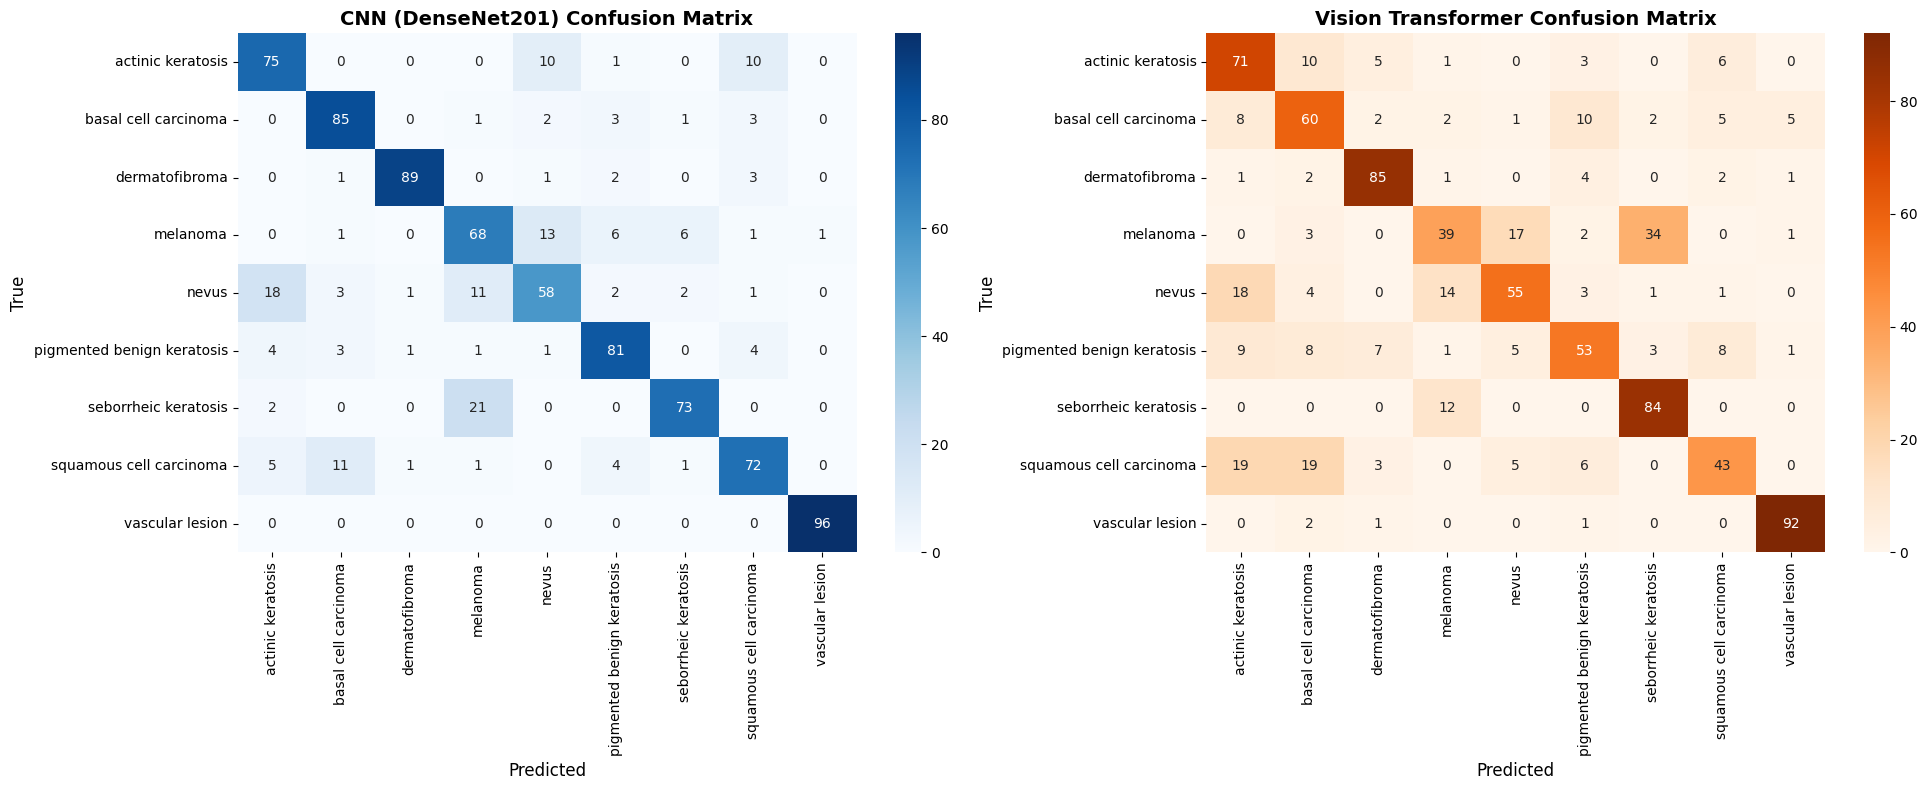

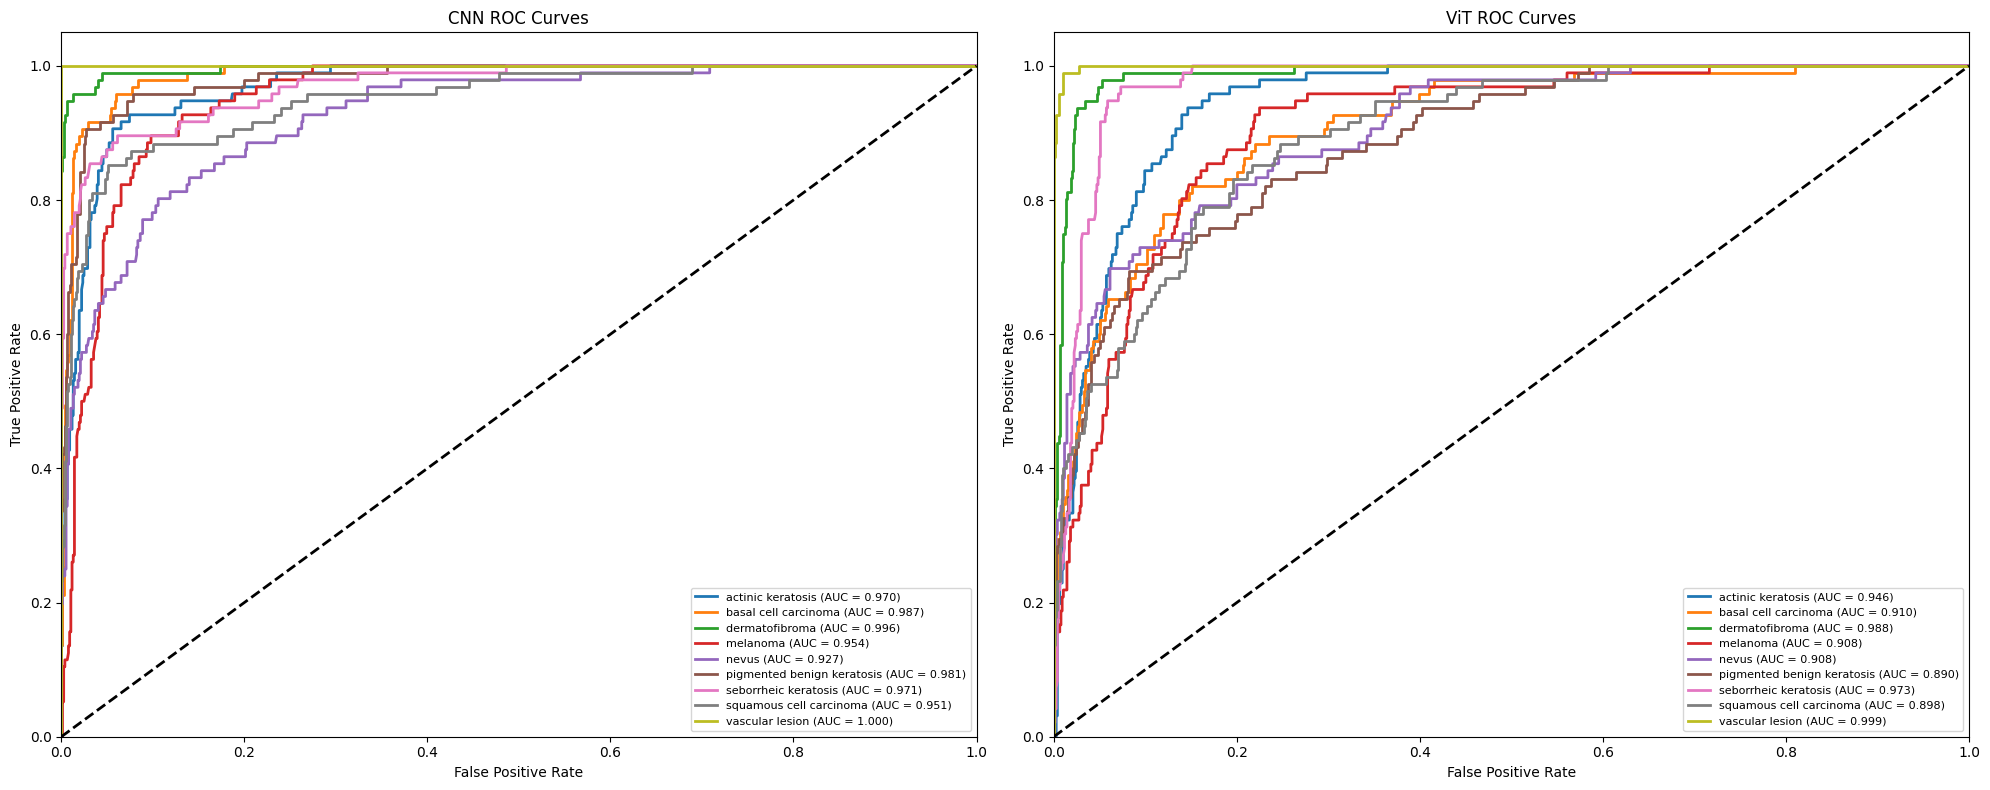

In [50]:
# Vẽ và log confusion matrices
cm_fig = plot_confusion_matrix_comparison()
wandb.log({"confusion_matrices": wandb.Image(cm_fig)})
plt.show()

# Vẽ ROC curves comparison
def plot_roc_comparison():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # CNN ROC curves
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], cnn_preds[:, i])
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('CNN ROC Curves')
    ax1.legend(loc="lower right", fontsize=8)
        # ViT ROC curves
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], vit_preds[:, i])
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ViT ROC Curves')
    ax2.legend(loc="lower right", fontsize=8)

    plt.tight_layout()
    return fig

# Vẽ và log ROC curves
roc_fig = plot_roc_comparison()
wandb.log({"roc_curves_comparison": wandb.Image(roc_fig)})
plt.show()


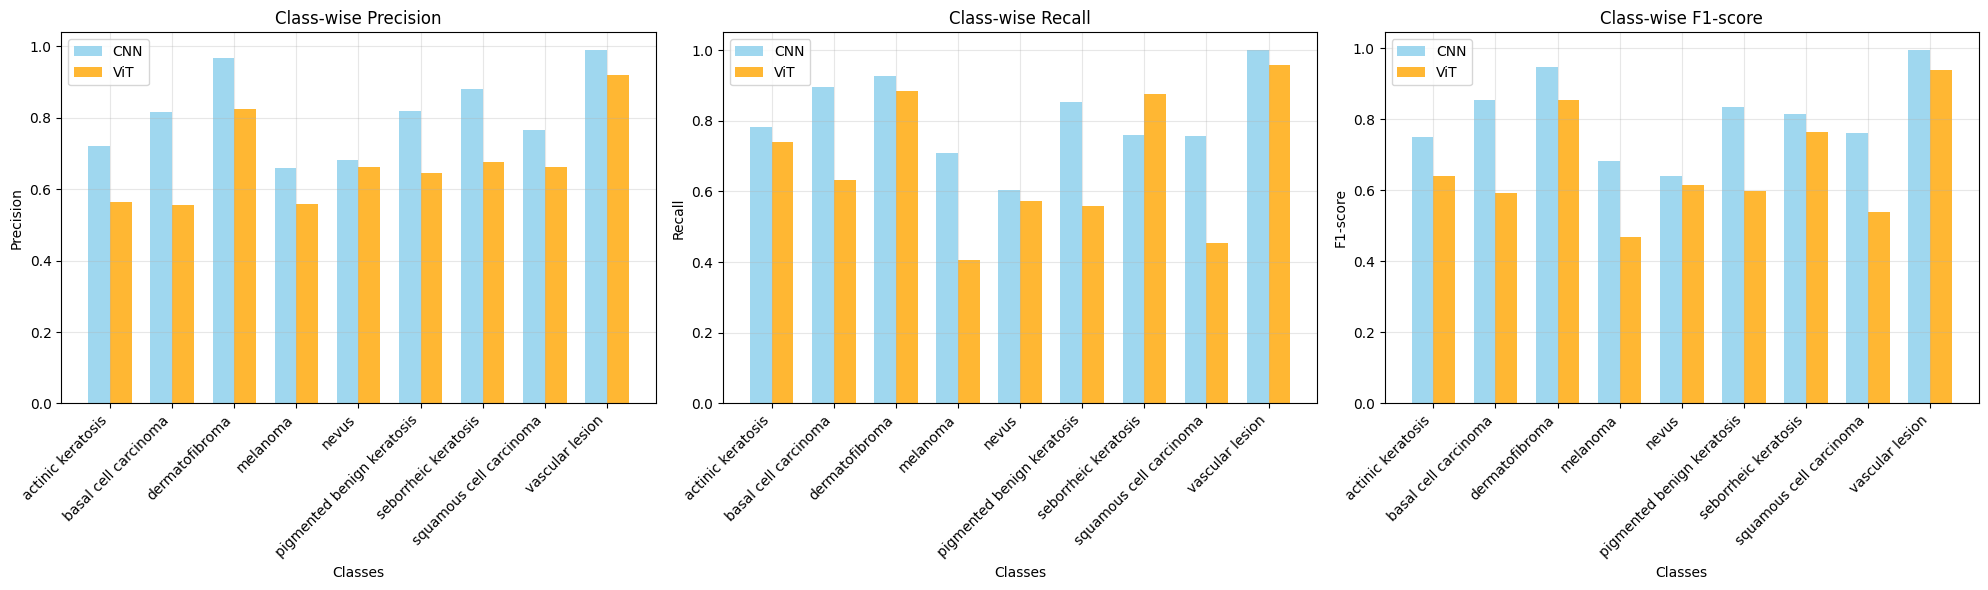

In [51]:
# Vẽ class-wise performance comparison
def plot_classwise_metrics():
    metrics = ['precision', 'recall', 'f1-score']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, metric in enumerate(metrics):
        cnn_values = [cnn_report[name][metric] for name in class_names]
        vit_values = [vit_report[name][metric] for name in class_names]

        x = np.arange(len(class_names))
        width = 0.35

        axes[idx].bar(x - width/2, cnn_values, width, label='CNN', alpha=0.8, color='skyblue')
        axes[idx].bar(x + width/2, vit_values, width, label='ViT', alpha=0.8, color='orange')

        axes[idx].set_xlabel('Classes')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].set_title(f'Class-wise {metric.capitalize()}')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(class_names, rotation=45, ha='right')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig
    # Vẽ và log class-wise metrics
classwise_fig = plot_classwise_metrics()
wandb.log({"classwise_metrics": wandb.Image(classwise_fig)})
plt.show()

In [52]:
# Vẽ biểu đồ so sánh tổng quan
def plot_overall_comparison():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy comparison
    models = ['CNN', 'ViT']
    accuracies = [cnn_accuracy*100, vit_accuracy*100]
    colors = ['skyblue', 'orange']

    bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.8)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Test Accuracy Comparison')
    ax1.set_ylim([0, 100])

    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

    # AUC comparison
    aucs = [cnn_avg_auc, vit_avg_auc]
    bars2 = ax2.bar(models, aucs, color=colors, alpha=0.8)
    ax2.set_ylabel('Average AUC')
    ax2.set_title('Average AUC Comparison')
    ax2.set_ylim([0, 1])

    for bar, auc_val in zip(bars2, aucs):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold')

    # Parameters comparison
    params = [cnn_params/1000000, vit_params/1000000]
    bars3 = ax3.bar(models, params, color=colors, alpha=0.8)
    ax3.set_ylabel('Parameters (Millions)')
    ax3.set_title('Model Size Comparison')

    for bar, param in zip(bars3, params):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                f'{param:.1f}M', ha='center', va='bottom', fontweight='bold')

    # F1-Score comparison
    f1_scores = [cnn_f1, vit_f1]
    bars4 = ax4.bar(models, f1_scores, color=colors, alpha=0.8)
    ax4.set_ylabel('F1-Score (Macro)')
    ax4.set_title('F1-Score Comparison')
    ax4.set_ylim([0, 1])

    for bar, f1 in zip(bars4, f1_scores):
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    return fig

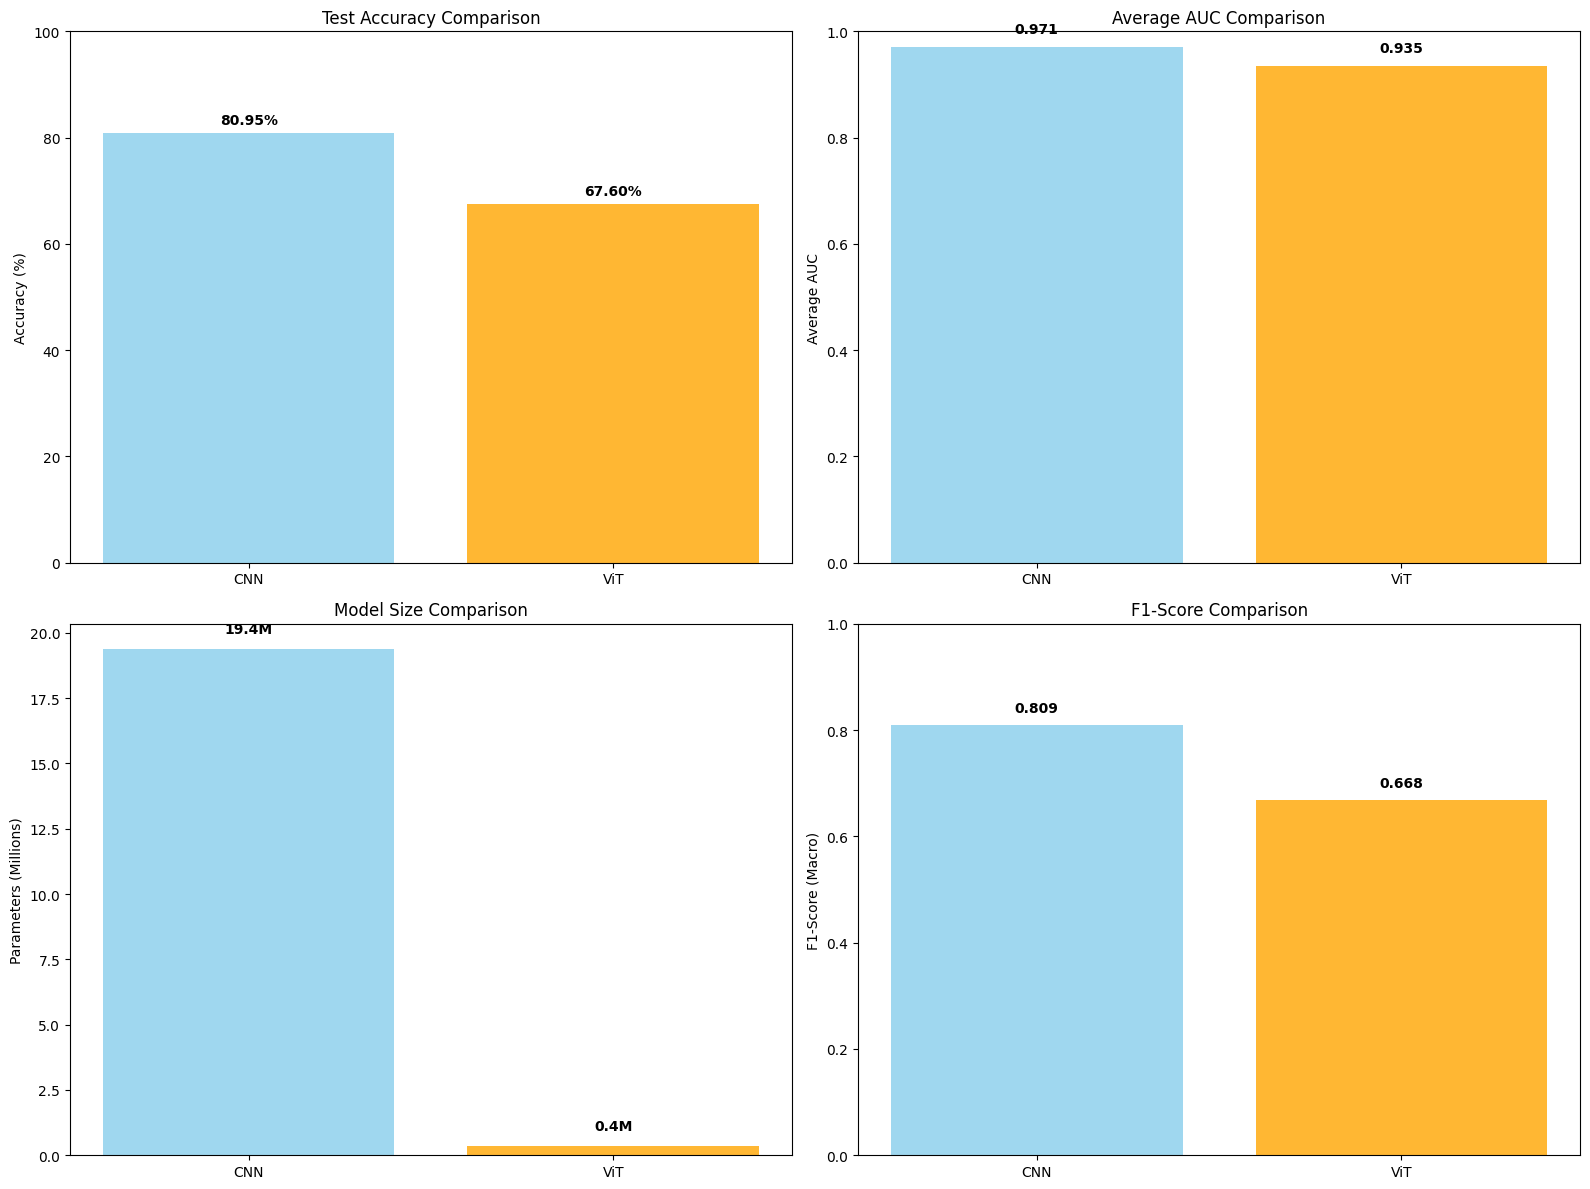


 Đang lưu trữ kết quả so sánh...
 Đã lưu kết quả so sánh vào:
  - model_comparison_detailed.csv
  - detailed_results.json

                    KẾT LUẬN SO SÁNH CNN VÀ VIT
 CNN Accuracy: 80.95% | ViT Accuracy: 67.60%
 CNN F1-Score: 0.8092 | ViT F1-Score: 0.6676
 CNN Avg AUC: 0.9708 | ViT Avg AUC: 0.9354
 CNN Parameters: 19.37M | ViT Parameters: 0.37M

 PHÂN TÍCH:
 CNN có hiệu suất cao hơn về accuracy (13.36% difference)
 ViT hiệu quả hơn về số parameters (52.7x ít hơn)

💡 RECOMMENDATIONS:
   Production deployment: Chọn CNN cho accuracy tối ưu
   Research/experimentation: ViT có tiềm năng với data lớn hơn
    Resource-constrained environments: ViT với ít parameters hơn
    Medical applications: CNN với accuracy cao và interpretability tốt
    Future scaling: ViT có khả năng scale tốt với dataset lớn


In [53]:
# Vẽ và log overall comparison
overall_fig = plot_overall_comparison()
wandb.log({"overall_comparison": wandb.Image(overall_fig)})
plt.show()

# Log individual metrics
wandb.log({
    "final/cnn_accuracy": cnn_accuracy,
    "final/vit_accuracy": vit_accuracy,
    "final/cnn_auc": cnn_avg_auc,
    "final/vit_auc": vit_avg_auc,
    "final/cnn_f1": cnn_f1,
    "final/vit_f1": vit_f1,
    "final/cnn_params": cnn_params,
    "final/vit_params": vit_params
})

# Lưu trữ kết quả
print("\n Đang lưu trữ kết quả so sánh...")
comparison_df.to_csv('model_comparison_detailed.csv', index=False)

# Lưu detailed report
detailed_report = {
    'CNN': {
        'accuracy': cnn_accuracy,
        'top5_accuracy': cnn_top5_acc,
        'precision': cnn_precision,
        'recall': cnn_recall,
        'f1_score': cnn_f1,
        'auc_scores': cnn_auc_scores,
        'avg_auc': cnn_avg_auc,
        'params': cnn_params,
        'classification_report': cnn_report
    },
    'ViT': {
        'accuracy': vit_accuracy,
        'top5_accuracy': vit_top5_acc,
        'precision': vit_precision,
        'recall': vit_recall,
        'f1_score': vit_f1,
        'auc_scores': vit_auc_scores,
        'avg_auc': vit_avg_auc,
        'params': vit_params,
        'classification_report': vit_report
    }
}


print(" Đã lưu kết quả so sánh vào:")
print("  - model_comparison_detailed.csv")
print("  - detailed_results.json")

# Kết luận và recommendations
print("\n" + "="*80)
print("                    KẾT LUẬN SO SÁNH CNN VÀ VIT")
print("="*80)
print(f" CNN Accuracy: {cnn_accuracy*100:.2f}% | ViT Accuracy: {vit_accuracy*100:.2f}%")
print(f" CNN F1-Score: {cnn_f1:.4f} | ViT F1-Score: {vit_f1:.4f}")
print(f" CNN Avg AUC: {cnn_avg_auc:.4f} | ViT Avg AUC: {vit_avg_auc:.4f}")
print(f" CNN Parameters: {cnn_params/1000000:.2f}M | ViT Parameters: {vit_params/1000000:.2f}M")

# Phân tích kết quả
if cnn_accuracy > vit_accuracy:
    accuracy_winner = "CNN"
    accuracy_diff = (cnn_accuracy - vit_accuracy) * 100
else:
    accuracy_winner = "ViT"
    accuracy_diff = (vit_accuracy - cnn_accuracy) * 100

if cnn_params > vit_params:
    efficiency_winner = "ViT"
    param_ratio = cnn_params / vit_params
else:
    efficiency_winner = "CNN"
    param_ratio = vit_params / cnn_params

print(f"\n PHÂN TÍCH:")
print(f" {accuracy_winner} có hiệu suất cao hơn về accuracy ({accuracy_diff:.2f}% difference)")
print(f" {efficiency_winner} hiệu quả hơn về số parameters ({param_ratio:.1f}x ít hơn)")

print(f"\n💡 RECOMMENDATIONS:")
if cnn_accuracy > vit_accuracy:
    print("   Production deployment: Chọn CNN cho accuracy tối ưu")
    print("   Research/experimentation: ViT có tiềm năng với data lớn hơn")
else:
    print("    Production deployment: ViT có accuracy tốt và efficiency cao")
    print("    Ensemble approach: Kết hợp cả hai cho best performance")

print("    Resource-constrained environments: ViT với ít parameters hơn")
print("    Medical applications: CNN với accuracy cao và interpretability tốt")
print("    Future scaling: ViT có khả năng scale tốt với dataset lớn")

print("="*80)

# Kết thúc W&B run
wandb.finish()




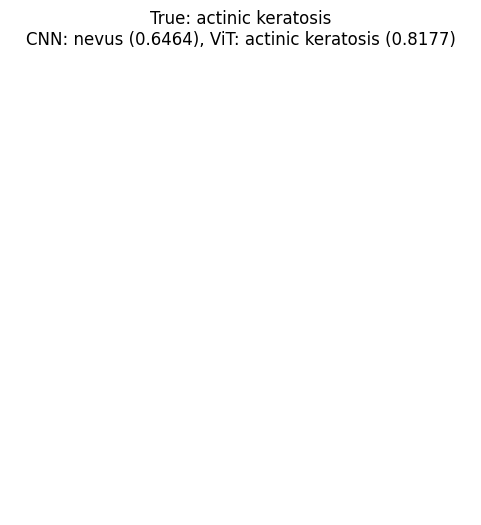

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


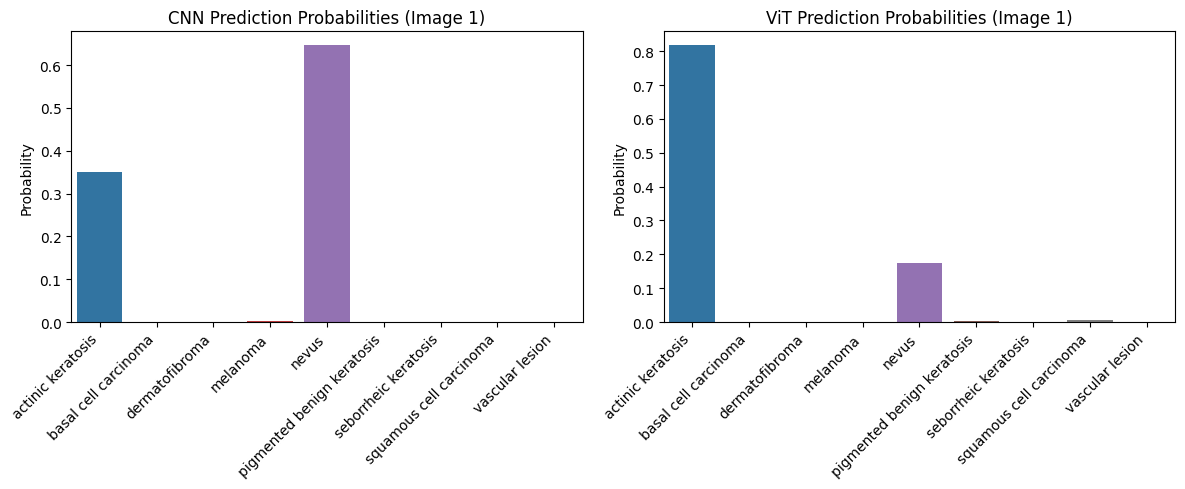

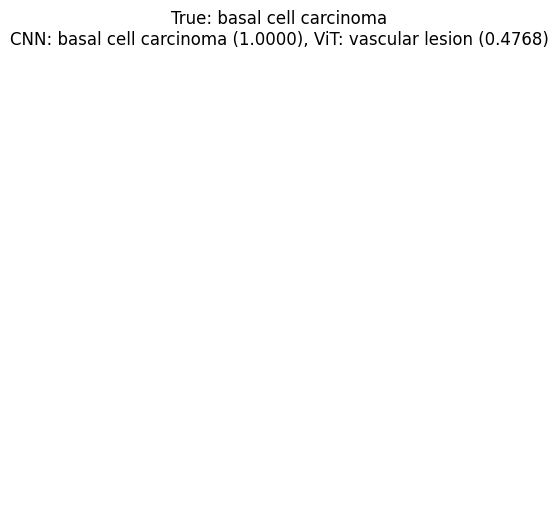

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


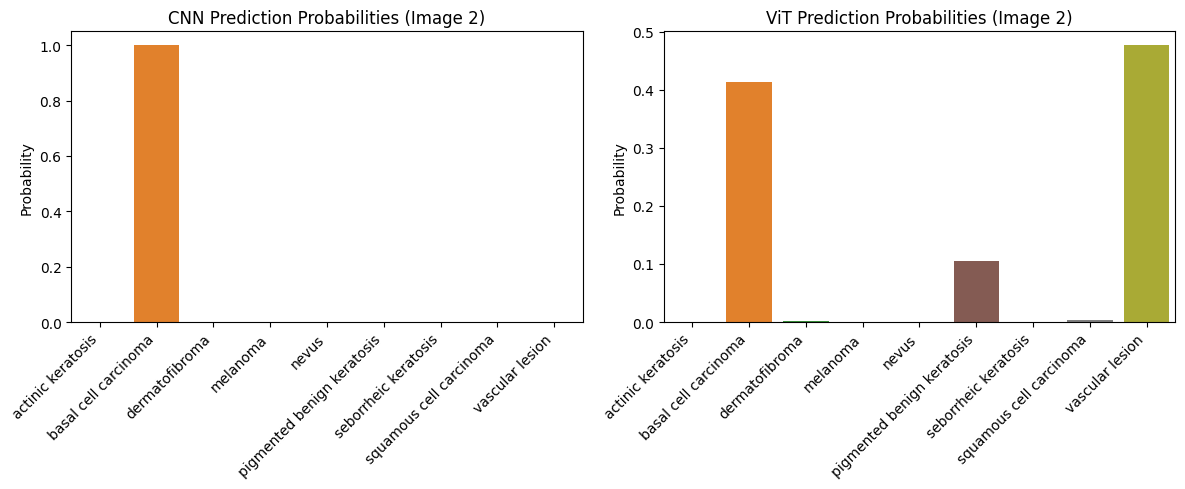

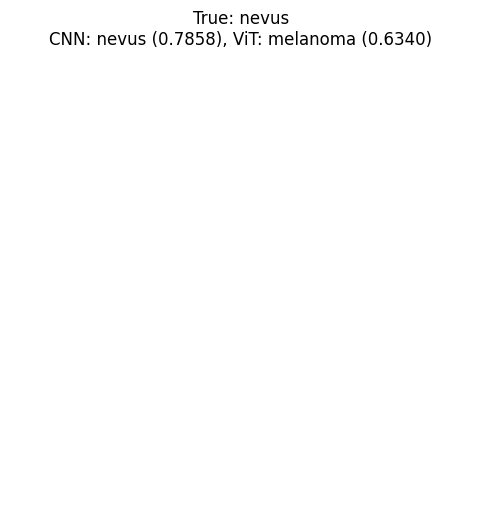

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


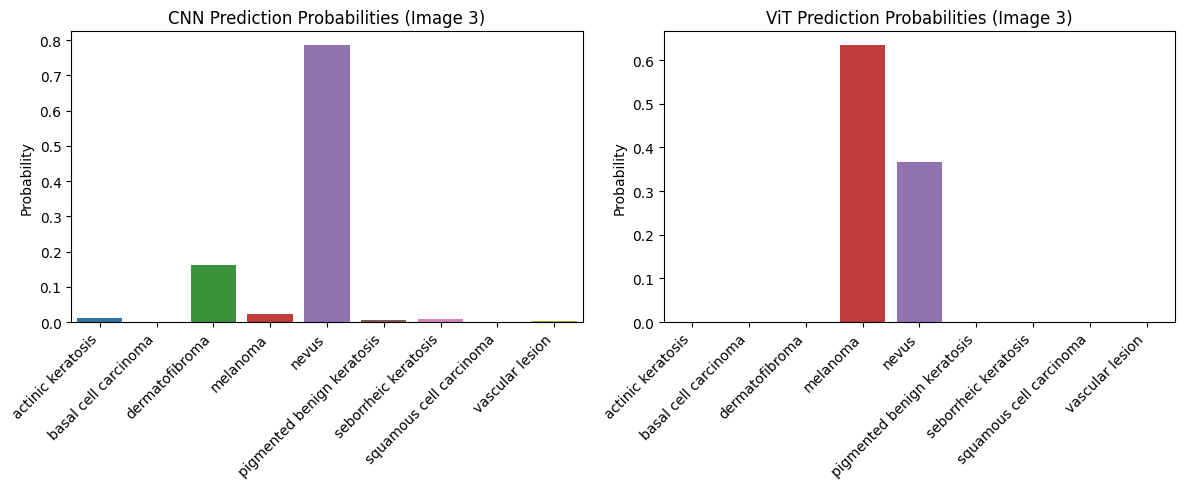

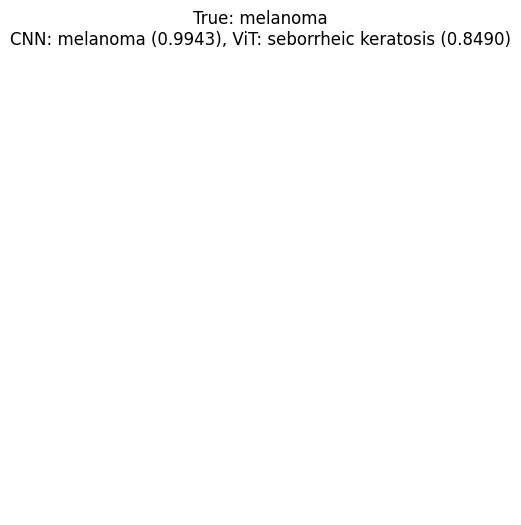

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


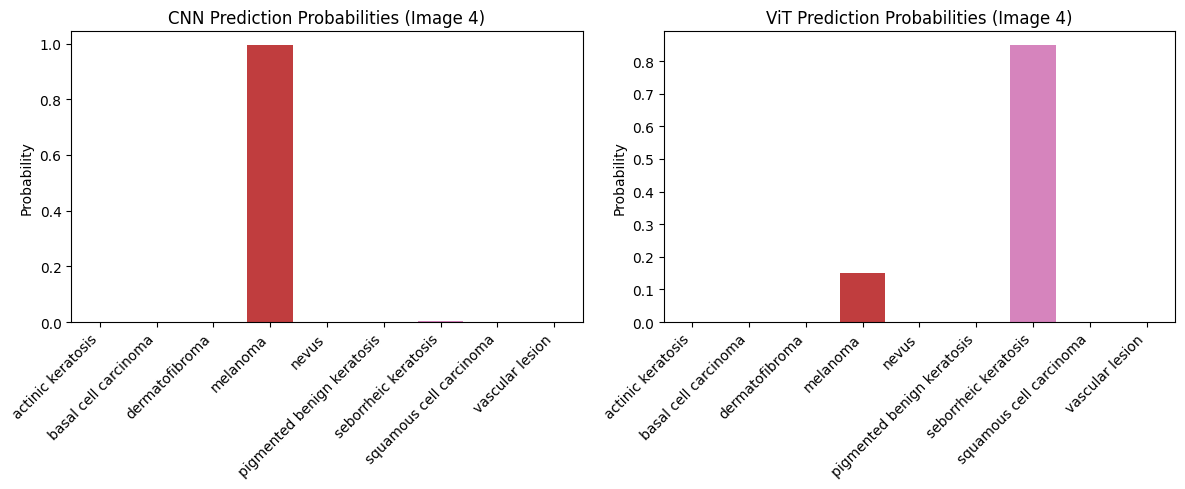

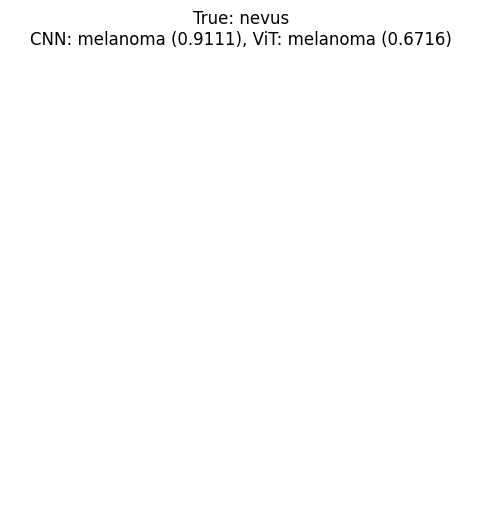

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


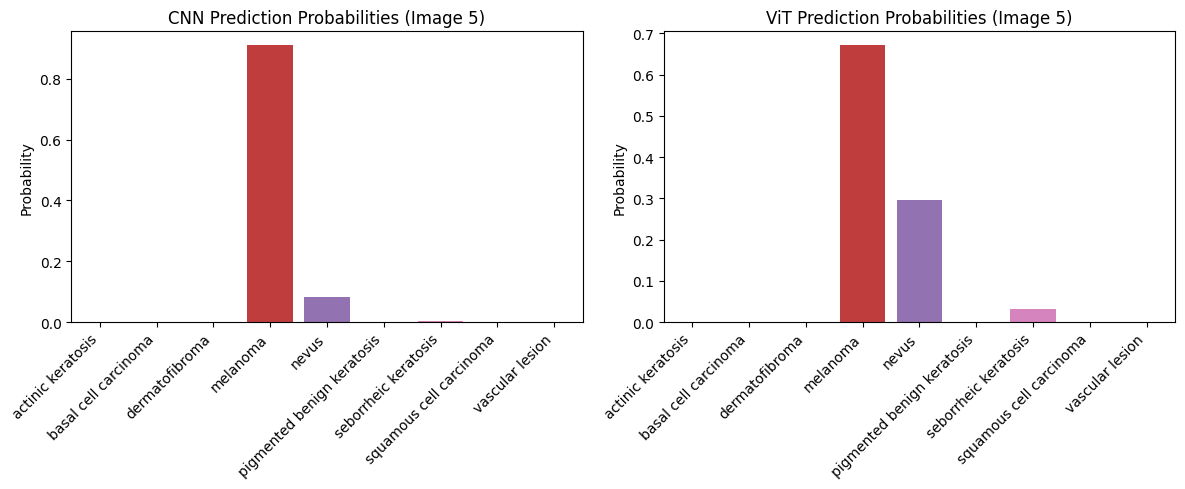

In [55]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Chọn 5 chỉ số ngẫu nhiên từ tập test
indices = random.sample(range(len(X_test)), 5)

for i, idx in enumerate(indices):
    test_img = X_test[idx]
    true_label = y_test[idx]

    # Denormalize để hiển thị
    img_display = (test_img * X_train_std + X_train_mean).clip(0, 1)

    # Thêm batch dimension
    test_img_input = np.expand_dims(test_img, axis=0)

    # Dự đoán với CNN
    cnn_pred = cnn_model.predict(test_img_input, verbose=0)
    cnn_class = np.argmax(cnn_pred, axis=1)[0]
    cnn_label = label_map[cnn_class]
    cnn_conf = cnn_pred[0][cnn_class]

    # Dự đoán với ViT
    vit_pred = vit_model.predict(test_img_input, verbose=0)
    vit_class = np.argmax(vit_pred, axis=1)[0]
    vit_label = label_map[vit_class]
    vit_conf = vit_pred[0][vit_class]

    # Hiển thị ảnh
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.title(f"True: {label_map[true_label]}\nCNN: {cnn_label} ({cnn_conf:.4f}), ViT: {vit_label} ({vit_conf:.4f})")
    plt.axis('off')
    plt.show()

    # Vẽ xác suất dự đoán
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.barplot(x=list(label_map.values()), y=cnn_pred[0])
    plt.title(f"CNN Prediction Probabilities (Image {i+1})")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Probability")

    plt.subplot(1, 2, 2)
    sns.barplot(x=list(label_map.values()), y=vit_pred[0])
    plt.title(f"ViT Prediction Probabilities (Image {i+1})")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Probability")

    plt.tight_layout()
    plt.show()


In [ ]:
----------------------------------------------------------